In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 3]
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels

import scipy
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
print(matplotlib.__version__)
print(pd.__version__)
print(np.__version__)
print(statsmodels.__version__)
print(scipy.__version__)


3.3.2
1.1.4
1.19.4
0.12.1
1.5.4


## Obtain and visualize data

In [3]:
## data obtained from https://datahub.io/core/global-temp#data
df = pd.read_csv("global_temps.csv")
df.head()

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292


In [4]:
df.shape

(3288, 3)

<AxesSubplot:>

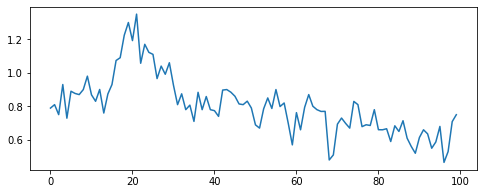

In [5]:
df.Mean[:100].plot()

<AxesSubplot:>

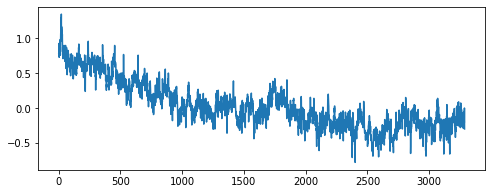

In [6]:
df.Mean.plot()

She is plotting the first 100 points.  She recommends it is sometime good NOT to plot the whole series because

## Exercise: what is wrong with the data and plot above? How can we fix this?

Answer: You are combining sources.  These are actually two separate time series. A hint to the error is that x-axis is not showing time for the time series.

So let's fix it: 

In [7]:
 df = df.pivot(index = 'Date', columns='Source', values='Mean')

In [8]:
df.index

Index(['1880-01-06', '1880-02-06', '1880-03-06', '1880-04-06', '1880-05-06',
       '1880-06-06', '1880-07-06', '1880-08-06', '1880-09-06', '1880-10-06',
       ...
       '2016-03-06', '2016-04-06', '2016-05-06', '2016-06-06', '2016-07-06',
       '2016-08-06', '2016-09-06', '2016-10-06', '2016-11-06', '2016-12-06'],
      dtype='object', name='Date', length=1644)

In [9]:
df.columns.to_list()

['GCAG', 'GISTEMP']

In [10]:
df.head()

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14


<AxesSubplot:xlabel='Date'>

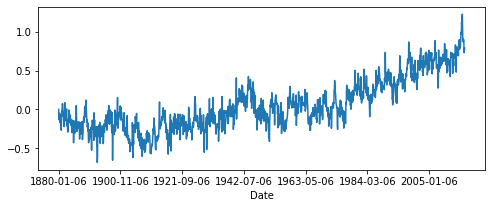

In [11]:
df.GCAG.plot()

In [12]:
type(df.index)

pandas.core.indexes.base.Index

## Exercise: how can we make the index more time aware?

**Really Important Trick!**

It makes it really easy to filter and select data based on date and date ranges.

In [13]:
df.index = pd.to_datetime(df.index)

In [14]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

<AxesSubplot:xlabel='Date'>

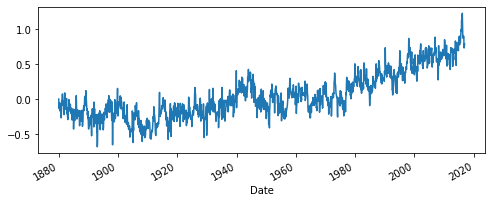

In [15]:
df.GCAG.plot()

In [16]:
df['1880']

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14
1880-06-06,-0.1692,-0.29
1880-07-06,-0.1491,-0.24
1880-08-06,-0.0725,-0.08
1880-09-06,-0.0817,-0.17


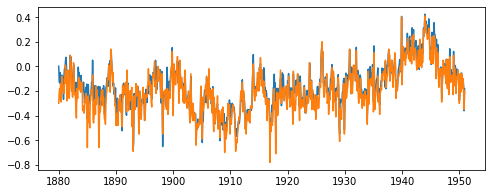

In [17]:
plt.plot(df['1880':'1950'][['GCAG', 'GISTEMP']])

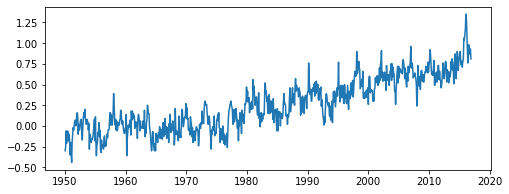

In [18]:
plt.plot(df['1950':][['GISTEMP']])

## Exercise: How strongly do these measurements correlate contemporaneously? What about with a time lag?

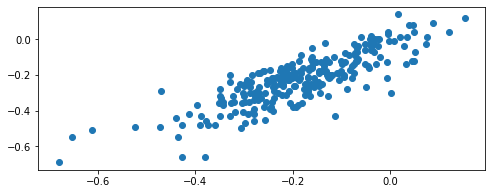

In [19]:
plt.scatter(df['1880':'1900'][['GCAG']], df['1880':'1900'][['GISTEMP']])

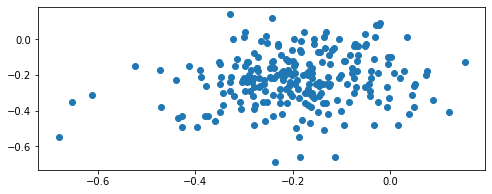

In [20]:
plt.scatter(df['1880':'1899'][['GCAG']], df['1881':'1900'][['GISTEMP']])

In [21]:
pearsonr(df['1880':'1899'].GCAG, df['1881':'1900'].GISTEMP)

(0.1546405732961276, 0.01650223473095511)

In [22]:
df['1880':'1899'][['GCAG']].head()

Source,GCAG
Date,
1880-01-06,0.0009
1880-02-06,-0.1229
1880-03-06,-0.1357
1880-04-06,-0.0499
1880-05-06,-0.0738


In [23]:
df['1881':'1900'][['GISTEMP']].head()

Source,GISTEMP
Date,
1881-01-06,-0.10
1881-02-06,-0.14
1881-03-06,0.01
1881-04-06,-0.03
1881-05-06,-0.04


In [24]:
min(df.index)

Timestamp('1880-01-06 00:00:00')

In [25]:
max(df.index)

Timestamp('2016-12-06 00:00:00')

## Unobserved component model OR structural time series 

UCM decomposes a time series into trend, seasonal, cyclical, and idiosyncratic components and allows for exogenous variables. UCM is an alternative to ARIMA models and provides a flexible and formal approach to smoothing and decomposition problems. [Medium Article](https://medium.com/analytics-vidhya/tsa-ucm-python-5fde69d42e28)

### Equation:

![UCM model equation](./images/ucm_equation.png)

![UCM model equation details](./images/ucm_equation_component_details.png)

**NOTE: The labeling in the second equation related to TREND is incorrect. v should be level, while u is trend**

![UCM model Seasonality](./images/seasonality_equation.png)

![UCM model Cycles](./images/cycle_equation.png)

### Components:

- Trend: The trend component is a dynamic extension of a regression model that includes an intercept and linear time-trend. the trend is a generalization of the time-trend such that the slope can dynamically vary across time.

    - Trends are loosely defined: **as the natural tendency of the series to increase or decrease or remain constant over a period of time in absence of any other influencing variable.**

    - UCM can model trend in two ways; first being the random walk model implying that trend remains roughly constant over the time period of the series, and the second being locally linear trend having an upward or downward slope

- Level: level is a generalization of the intercept term that can dynamically vary across time

- Seasonality: A seasonal pattern exists when there exists a consistent pattern of variation influenced by seasonal factors (e.g., the quarter of the year, or day of the week, etc.).

    - The periodicity (number of seasons) is s, and the defining character is that (without the error term), the sum of the seasonal components is zero across one complete cycle.

    - The inclusion of an error term allows the seasonal effects to vary over time. If the seasonal effect is stochastic, then there is one additional parameter to estimate via MLE (the variance of the error term).

- Cycles: The cyclical component is intended to capture cyclical effects at time frames much longer than captured by the seasonal component. For example, in economics, the cyclical term is often intended to capture the business cycle and is then expected to have a period between “1.5 and 12 years”.

### Examples

#### Trend
![Trend Examples](./images/trend_examples.png)

#### Seasonality
![Seasonality Examples](./images/seasonality_examples.png)

#### Cycles
![Cycle Examples](./images/cycle_examples.png)

### Model Decisions

- For both elements (level and trend), we can consider models in which 1) the element is included vs excluded (if the trend is included, there must also be a level included) and 2) the element is deterministic vs stochastic (i.e. whether or not the variance on the error term is zero or not)


In [26]:
train = df['1960':]

### model parameters

Simple first pass model

In [27]:
# smooth trend model without seasonal or cyclical components
# Simple first pass model.
model = {
    'level': 'smooth trend', 'cycle': False, 'seasonal': None, 
}


### fitting a model

In [28]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html
gcag_mod = sm.tsa.UnobservedComponents(train['GCAG'], **model)
gcag_res = gcag_mod.fit()

/Users/ugochi/.pyenv/versions/time_series_20201108/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


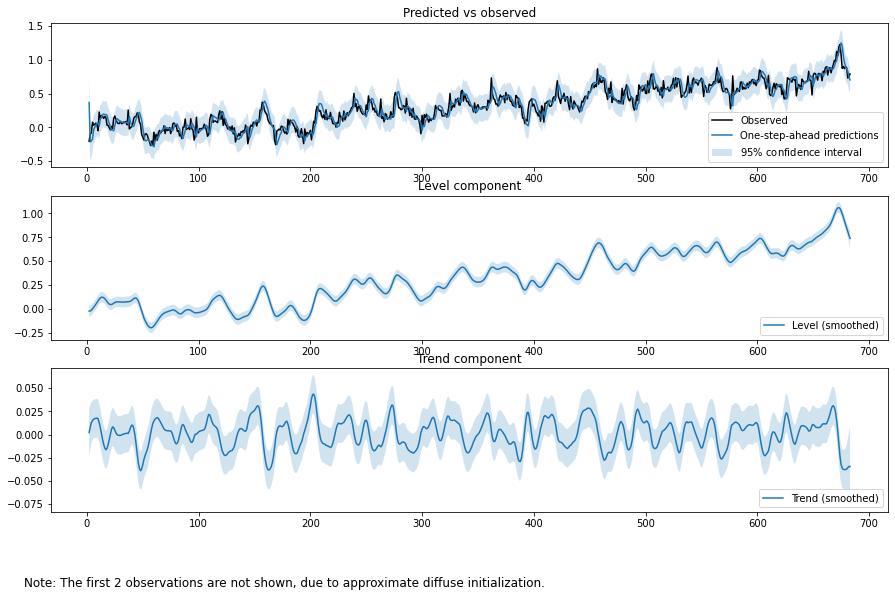

In [29]:
fig = gcag_res.plot_components(legend_loc='lower right', figsize=(15, 9));

In this case, one-step ahead means we are predicting the value 1 month ahead from the current time point.

## Plotting predictions

In [30]:
# Perform rolling prediction and multistep forecast
num_steps = 20 #want to predict 20 months (20 predictions (about monthly values) at for each time step)
predict_res = gcag_res.get_prediction(dynamic=train['GCAG'].shape[0] - num_steps)

predict = predict_res.predicted_mean
ci = predict_res.conf_int()

In the previous step using dynamic predicting (where the rolling comes into play).  Now you have a train window and predict (time horizon) window.  Train window is everything prior to the last 20 steps in the series.  After the model creates itself base on the train window, it begins predicting 20 points (in our case month values). It predicting 20 months ahead.  It is not doing one step ahead and revising anymore.  Instead, it will take those 20 points and predict the next 20 points.  And it will do this continuously. (approximate explanation in video time: 49:15)

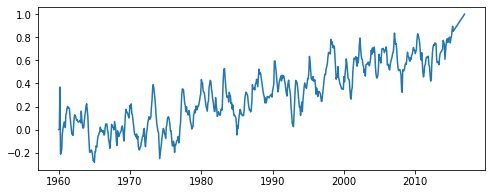

In [31]:
plt.plot(predict)

At the end of the time series flat line.  Why you see this is in multi-step horizons, it assumes no error.  So it will just keep rolling with the model (model bias).

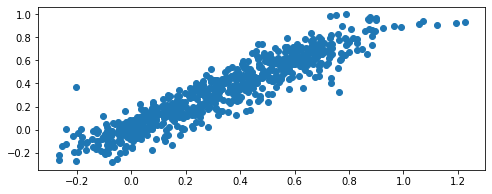

In [32]:
plt.scatter(train['GCAG'], predict)

Looks good here, but need to compare with null model

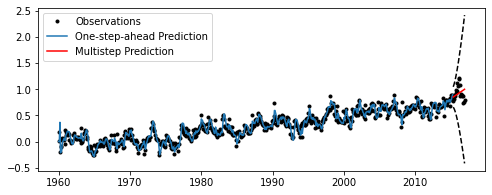

In [33]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train['GCAG'], 'k.', label='Observations');
ax.plot(train.index[:-num_steps], predict[:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

In [ ]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train.index[-40:], train['GCAG'][-40:], 'k.', label='Observations');
ax.plot(train.index[-40:-num_steps], predict[-40:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

## Exercise: consider adding a seasonal term for 12 periods for the model fit above. Does this improve the fit of the model?

In [ ]:
seasonal_model = {
    'level': 'local linear trend',
    'seasonal': 12
}
mod = sm.tsa.UnobservedComponents(train['GCAG'], **seasonal_model)
res = mod.fit(method='powell', disp=False)

In [ ]:
fig = res.plot_components(legend_loc='lower right', figsize=(15, 9));

## How does this compare to the original model?

In [ ]:
pearsonr(gcag_res.predict(), train['GCAG'])

In [ ]:
np.mean(np.abs(gcag_res.predict() - train['GCAG']))

In [ ]:
np.mean(np.abs(res.predict() - train['GCAG']))

## Explore the seasonality more

In [ ]:
seasonal_model = {
    'level': 'local level',
    'seasonal': 12
}
llmod = sm.tsa.UnobservedComponents(train['GCAG'], **seasonal_model)
ll_level_res = llmod.fit(method='powell', disp=False)

In [ ]:
fig = ll_level_res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [ ]:
np.mean(np.abs(ll_level_res.predict() - train['GCAG']))

In [ ]:
train[:48].GCAG.plot()

## Exercise: a common null model for time series is to predict the value at time t-1 for the value at time t. How does such a model compare to the models we fit here?

### Consider correlation

In [ ]:
pearsonr(ll_level_res.predict(), train['GCAG'])

In [ ]:
pearsonr(train['GCAG'].iloc[:-1, ], train['GCAG'].iloc[1:, ])

### What about mean absolute error?

In [ ]:
np.mean(np.abs(ll_level_res.predict() - train['GCAG']))

In [ ]:
np.mean(np.abs(train['GCAG'].iloc[:-1, ].values, train['GCAG'].iloc[1:, ].values))